In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-11-27 22:26:56.690528: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-27 22:27:09.291173: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-11-27 22:27:09.320387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-27 22:27:09.320425: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-27 22:27:09.322729: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-11-27 22:27:09.325024: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps) 
    
t_star = t_star[100::4]
data = data[..., 100::4]
T = t_star.shape[0]    
    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N//100,
                'pde_data_size': (T*N)//100,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'signal_to_noise':0.0,
                'shuffle':False}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.concatenate([dataset['obs_input'], dataset['obs_output']], axis=1)
pde_X = dataset['pde']

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

In [6]:
pde_X.shape

(16800, 3)

In [7]:
data.shape

(2, 100, 100, 168)

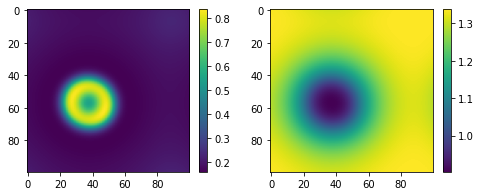

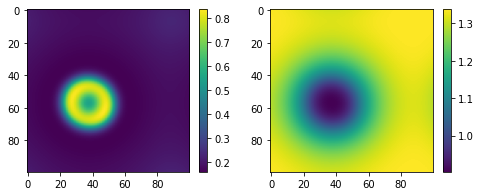

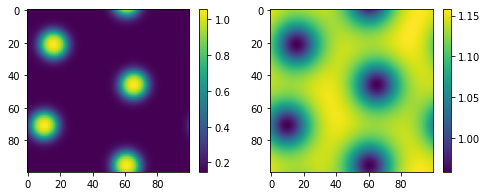

In [8]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(dataset['obs_output'][0:N, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(dataset['obs_output'][0:N, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

# _ = plt.figure(figsize=(8,4))
# plt.subplot(121)
# plt.imshow(dataset['obs_output'][(T-1)*N:, 0].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.subplot(122)
# plt.imshow(dataset['obs_output'][(T-1)*N:, 1].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.show()

In [9]:
dxdy = x_size*y_size/L**2
diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [10]:
T

168

In [11]:
model_params = {'training_data_size': T*N,
                'pde_data_size': (T*N),
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'signal_to_noise':0.0,
                'shuffle':True}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.concatenate([dataset['obs_input'], dataset['obs_output']], axis=1)
#pde_X = dataset['pde']
pde_X = dataset['obs_input']

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)
diffs_point = np.concatenate([dataset['obs_input'], dataset['diff_output']], axis=1)

In [12]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)

In [13]:
ds.sizes

array([1680000, 1680000,   33600])

In [14]:
layers = [3, 1024, 1024, 1024, 1024, 2]
#layers = [3, 512, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
#layers = [3, 128, 128, 128, 128, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   # alpha_u = alpha_u,
                   # alpha_v = alpha_v,
                   regularise=True,
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
obs_loss = Observation_Loss(regularise=True)
pbc_loss = Periodic_Boundary_Condition(regularise=True)
diff_loss_point = Diffusion_point_Loss(
                            Ds = simulation.Ds,
                            dtype = pinnKM.dtype)
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])

modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  losses= [obs_loss, pde_resKM, pbc_loss], 
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  loss_penalty_power=2,
                  alpha = 0.9, 
                  print_precision=".8f")

In [15]:
16800/32

525.0

In [15]:
results_KM = modelKM.train(epochs = 20+1,
                          batch_size = 525,
                          dataset = ds,
                          print_interval=1,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0


2022-11-27 22:28:22.366734: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-27 22:28:34.381871: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.00000000
total loss: 152.84864304, total regularise loss: 149.87963867

Observation_Loss ->  (1): 0.03642840  (2): 0.00871841 
Loss_Koch_Meinhard ->  (1): 0.00051694  (2): 0.00024583 
Periodic_Boundary_Condition ->  (1): 0.00092781 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 
lambdas (5): 1.00000000 
Time taken: 391.97s

Start of epoch 1
Training observations acc over epoch: 0.00000000
total loss: 287.99132560, total regularise loss: 226.76976013

Observation_Loss ->  (1): 0.03676738  (2): 0.01293266 
Loss_Koch_Meinhard ->  (1): 0.00124434  (2): 0.00078948 
Periodic_Boundary_Condition ->  (1): 0.01913171 


lambdas (1): 1.37412453 lambdas (2): 0.91373372 lambdas (3): 0.90019637 lambdas (4): 0.90009016 
lambdas (5): 0.91185522 
Time taken: 208.30s

Start of epoch 2
Training observations acc over epoch: 0.00000000
total loss: 133.17119792, total regularise loss: 169.91583252

Observation_Loss -

Training observations acc over epoch: 0.00000000
total loss: 10.33137848, total regularise loss: 10.40293980

Observation_Loss ->  (1): 0.00057570  (2): 0.00084688 
Loss_Koch_Meinhard ->  (1): 0.00016215  (2): 0.00073741 
Periodic_Boundary_Condition ->  (1): 0.00045321 


lambdas (1): 1.28573513 lambdas (2): 1.22749424 lambdas (3): 0.32499906 lambdas (4): 1.62223518 
lambdas (5): 0.53953624 
Time taken: 198.42s

Start of epoch 20
Training observations acc over epoch: 0.00000000
total loss: 9.93766205, total regularise loss: 10.16033840

Observation_Loss ->  (1): 0.00057876  (2): 0.00084730 
Loss_Koch_Meinhard ->  (1): 0.00015650  (2): 0.00068705 
Periodic_Boundary_Condition ->  (1): 0.00041796 


lambdas (1): 1.22975302 lambdas (2): 1.26449418 lambdas (3): 0.32269219 lambdas (4): 1.66191447 
lambdas (5): 0.52114594 
Time taken: 198.12s


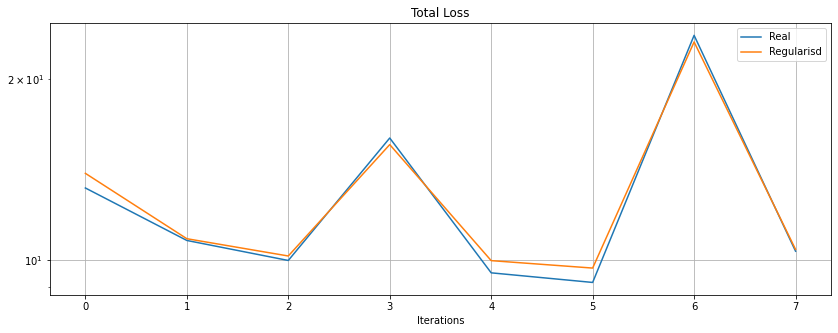

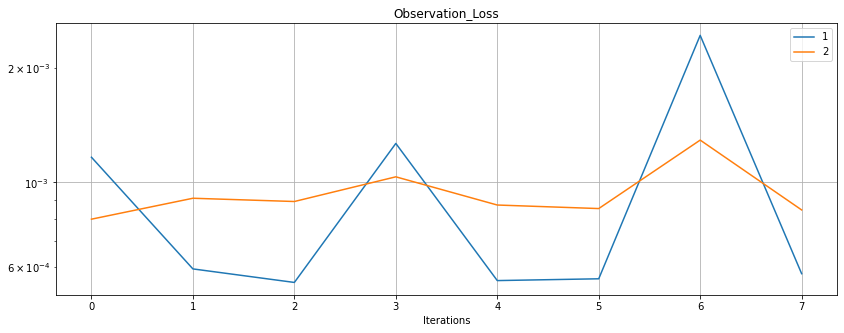

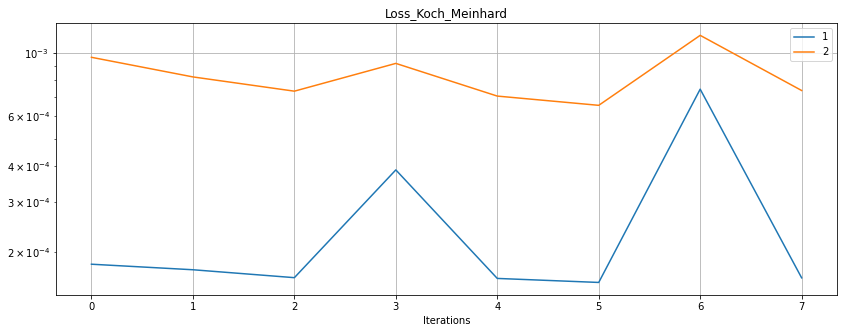

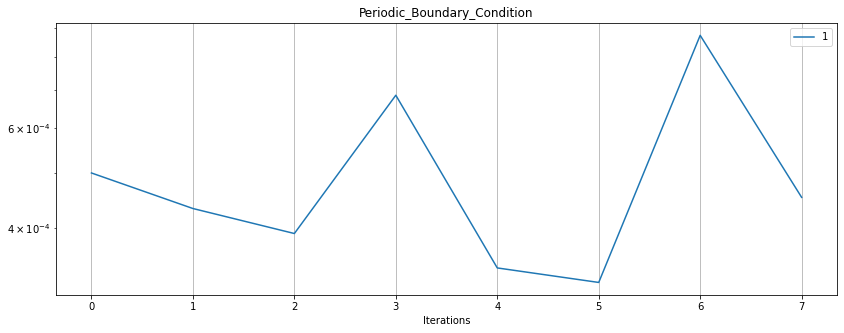

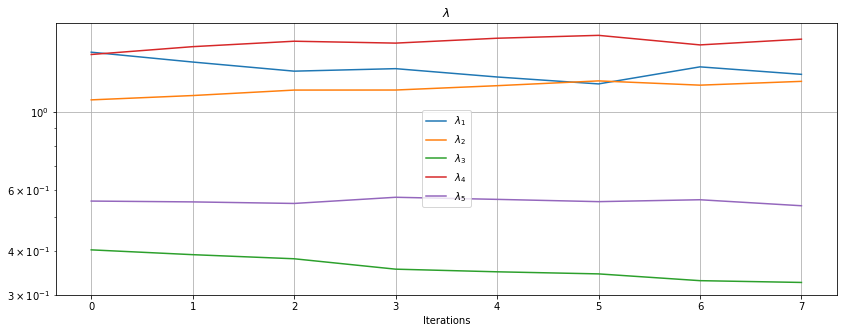

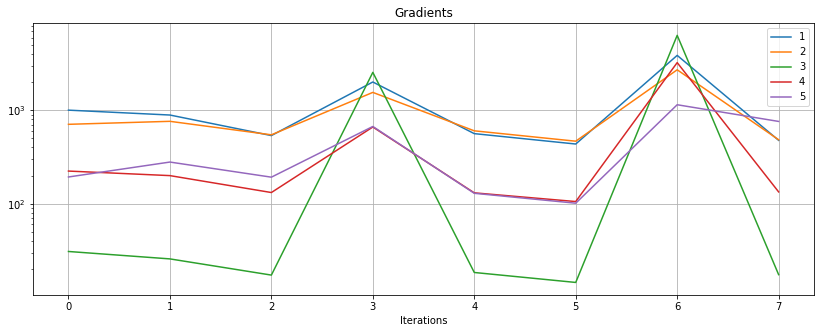

In [16]:
plot_result(merge_dict(results_KM), modelKM,start =12, yscale="log")#, y_lims=[0.01, 2])

In [17]:
results_KM2 = modelKM.train(epochs = 40+1,
                          batch_size = 525,
                          dataset = ds,
                          print_interval=1,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 9.54617904, total regularise loss: 9.88485241

Observation_Loss ->  (1): 0.00058465  (2): 0.00082215 
Loss_Koch_Meinhard ->  (1): 0.00015232  (2): 0.00064953 
Periodic_Boundary_Condition ->  (1): 0.00038727 


lambdas (1): 1.22975302 lambdas (2): 1.26449418 lambdas (3): 0.32269219 lambdas (4): 1.66191447 
lambdas (5): 0.52114594 
Time taken: 346.74s

Start of epoch 1
Training observations acc over epoch: 0.00000000
total loss: 9.21662861, total regularise loss: 9.62334919

Observation_Loss ->  (1): 0.00055914  (2): 0.00081597 
Loss_Koch_Meinhard ->  (1): 0.00014959  (2): 0.00063255 
Periodic_Boundary_Condition ->  (1): 0.00036147 


lambdas (1): 1.18400371 lambdas (2): 1.30571043 lambdas (3): 0.32109392 lambdas (4): 1.68514776 
lambdas (5): 0.50404394 
Time taken: 197.56s

Start of epoch 2
Training observations acc over epoch: 0.00000000
total loss: 13.05429672, total regularise loss: 12.40354824

Observatio

Training observations acc over epoch: 0.00000000
total loss: 8.91788406, total regularise loss: 9.74926758

Observation_Loss ->  (1): 0.00061691  (2): 0.00076878 
Loss_Koch_Meinhard ->  (1): 0.00015532  (2): 0.00064271 
Periodic_Boundary_Condition ->  (1): 0.00030156 


lambdas (1): 1.12785673 lambdas (2): 1.38231599 lambdas (3): 0.27941903 lambdas (4): 1.68850613 
lambdas (5): 0.52190232 
Time taken: 197.40s

Start of epoch 20
Training observations acc over epoch: 0.00000000
total loss: 8.69856870, total regularise loss: 9.48904324

Observation_Loss ->  (1): 0.00061073  (2): 0.00076679 
Loss_Koch_Meinhard ->  (1): 0.00015260  (2): 0.00060514 
Periodic_Boundary_Condition ->  (1): 0.00029152 


lambdas (1): 1.10561955 lambdas (2): 1.38606966 lambdas (3): 0.28523934 lambdas (4): 1.70572352 
lambdas (5): 0.51734817 
Time taken: 196.80s

Start of epoch 21
Training observations acc over epoch: 0.00000000
total loss: 8.57087962, total regularise loss: 9.36205387

Observation_Loss ->  (1): 0.

Training observations acc over epoch: 0.00000000
total loss: 9.10893013, total regularise loss: 9.55427170

Observation_Loss ->  (1): 0.00057016  (2): 0.00074846 
Loss_Koch_Meinhard ->  (1): 0.00015346  (2): 0.00063106 
Periodic_Boundary_Condition ->  (1): 0.00037170 


lambdas (1): 1.14369953 lambdas (2): 1.40150750 lambdas (3): 0.28323060 lambdas (4): 1.68699813 
lambdas (5): 0.48456413 
Time taken: 197.39s

Start of epoch 39
Training observations acc over epoch: 0.00000000
total loss: 8.68131466, total regularise loss: 9.28960800

Observation_Loss ->  (1): 0.00057524  (2): 0.00074445 
Loss_Koch_Meinhard ->  (1): 0.00015157  (2): 0.00059388 
Periodic_Boundary_Condition ->  (1): 0.00032389 


lambdas (1): 1.11855280 lambdas (2): 1.41089678 lambdas (3): 0.29017830 lambdas (4): 1.70770478 
lambdas (5): 0.47266725 
Time taken: 197.44s

Start of epoch 40
Training observations acc over epoch: 0.00000000
total loss: 8.45710180, total regularise loss: 9.13612366

Observation_Loss ->  (1): 0.

In [ ]:
Observation_Loss ->  (1): 0.00043580  (2): 0.00054329 
Loss_Koch_Meinhard ->  (1): 0.00011945  (2): 0.00054593 

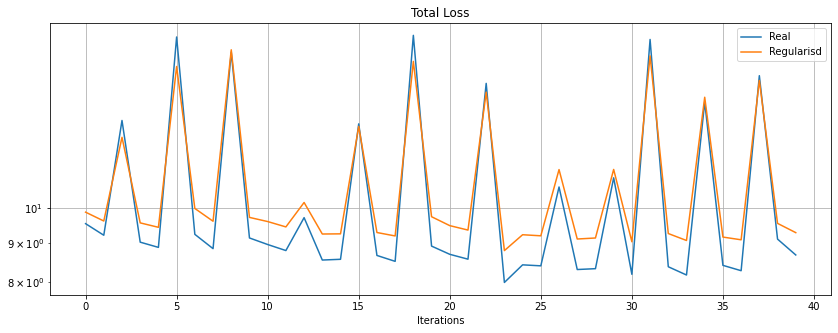

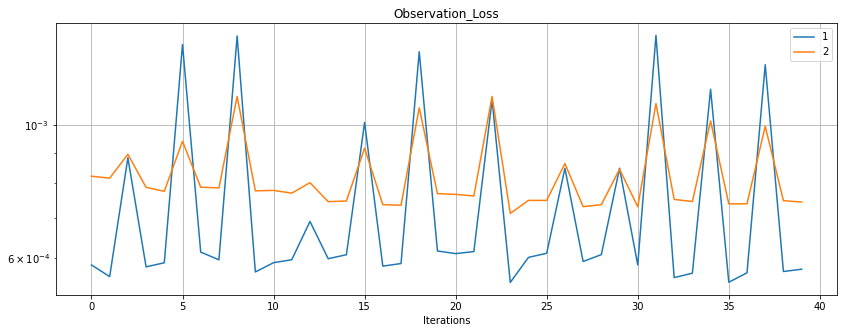

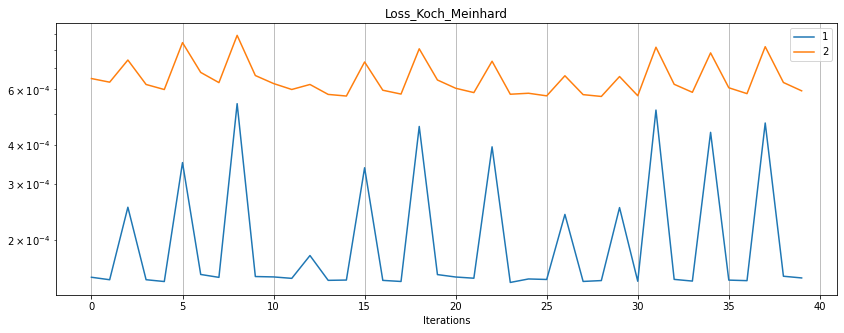

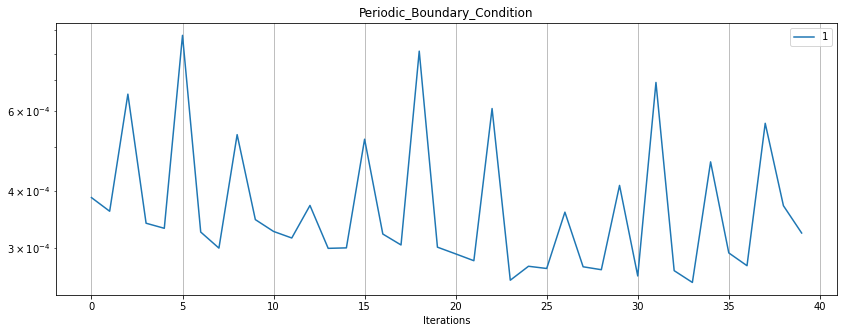

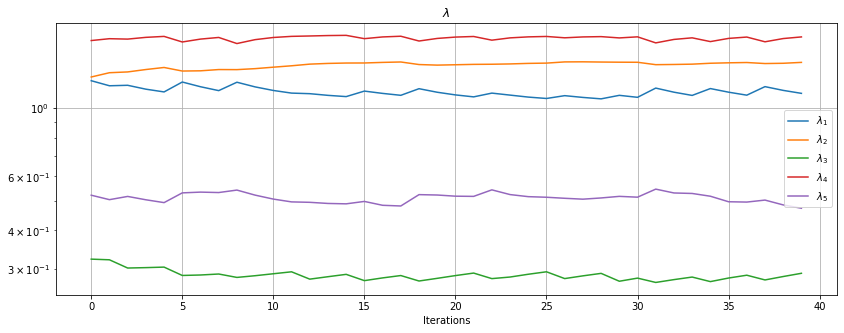

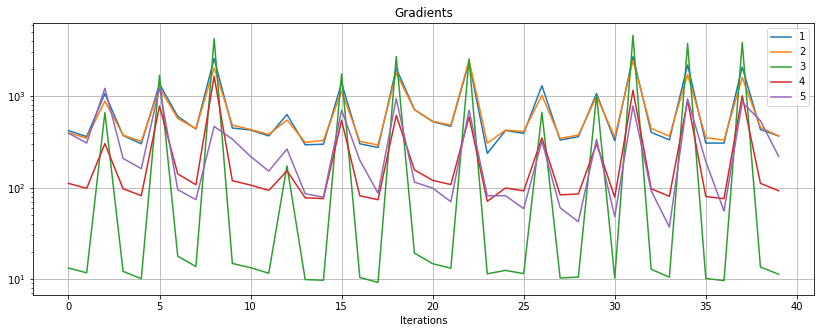

In [18]:
plot_result(merge_dict(results_KM2), modelKM,start =0, yscale="log")#, y_lims=[0.01, 2])

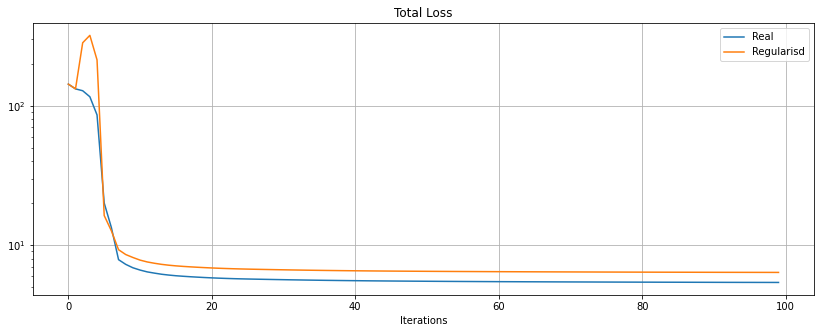

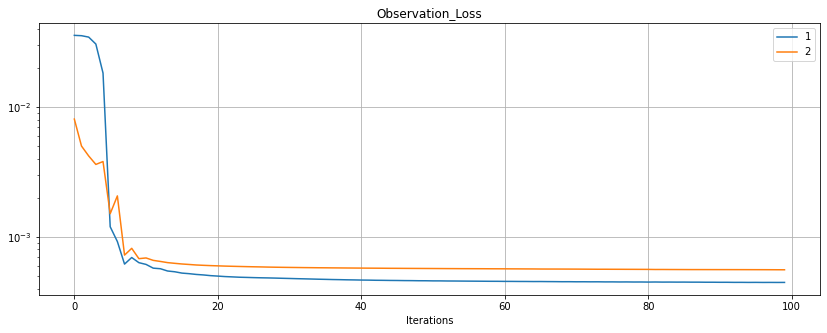

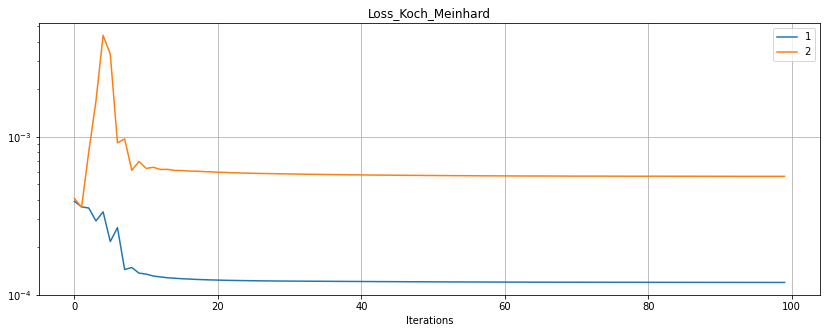

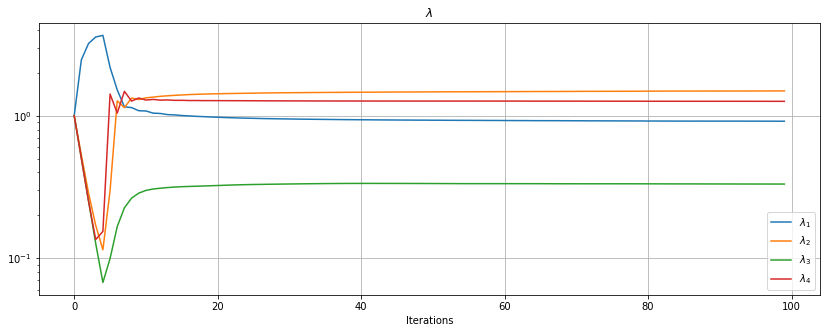

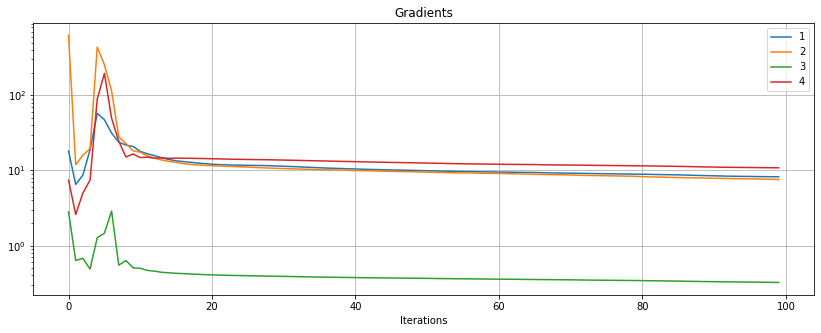

In [18]:
plot_result(merge_dict(results_KM), modelKM,start =0, yscale="log")#, y_lims=[0.01, 2])

In [16]:
results_KM = modelKM.train(epochs = 1000+1,
                          batch_size = 525,
                          dataset = ds,
                          print_interval=500,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)




Start of epoch 0


2022-11-24 15:36:35.984167: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-24 15:36:42.228136: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.00000000
total loss: 146.19372609, total regularise loss: 146.19395447

Observation_Loss ->  (1): 0.03528298  (2): 0.00962780 
Loss_Koch_Meinhard ->  (1): 0.00038613  (2): 0.00038864 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 213.98s

Start of epoch 500
Training observations acc over epoch: 0.00000000
total loss: 5.28170818, total regularise loss: 6.29837132

Observation_Loss ->  (1): 0.00043825  (2): 0.00054901 
Loss_Koch_Meinhard ->  (1): 0.00012004  (2): 0.00054324 


lambdas (1): 0.90817547 lambdas (2): 1.52803826 lambdas (3): 0.27928126 lambdas (4): 1.28450489 

Time taken: 44168.65s

Start of epoch 1000
Training observations acc over epoch: 0.00000000
total loss: 5.26232694, total regularise loss: 6.27560377

Observation_Loss ->  (1): 0.00043580  (2): 0.00054329 
Loss_Koch_Meinhard ->  (1): 0.00011945  (2): 0.00054593 


lambdas (1): 0.90656602 lambdas (2): 1.53763676 lam

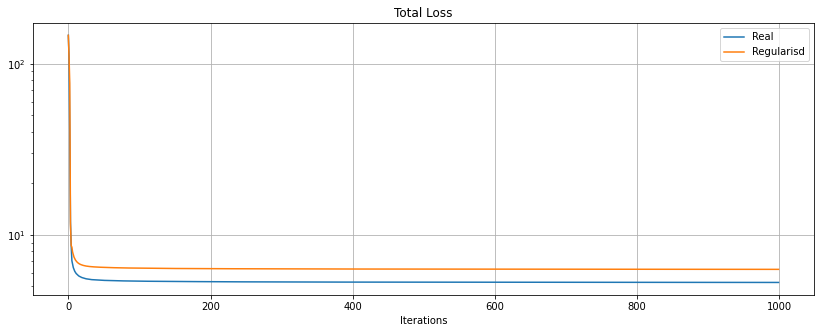

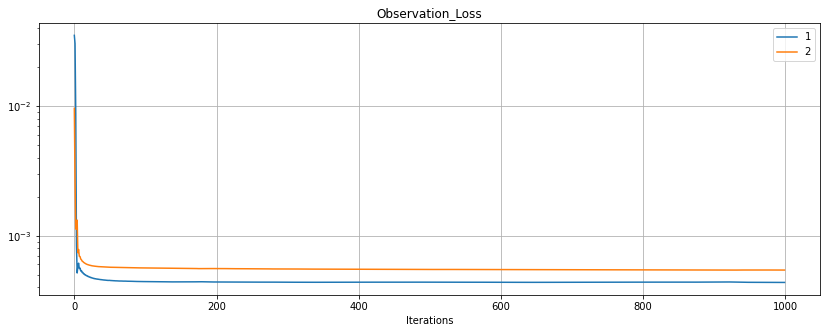

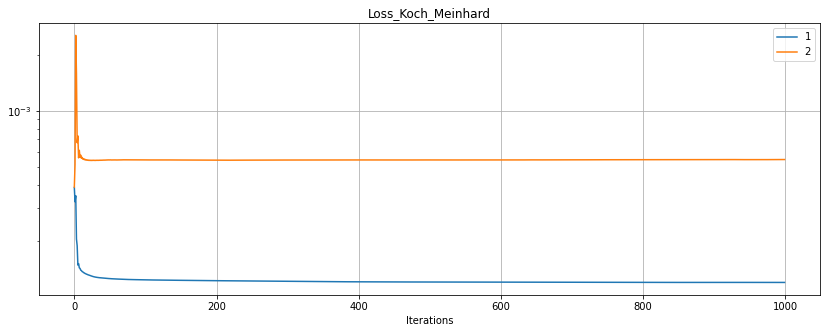

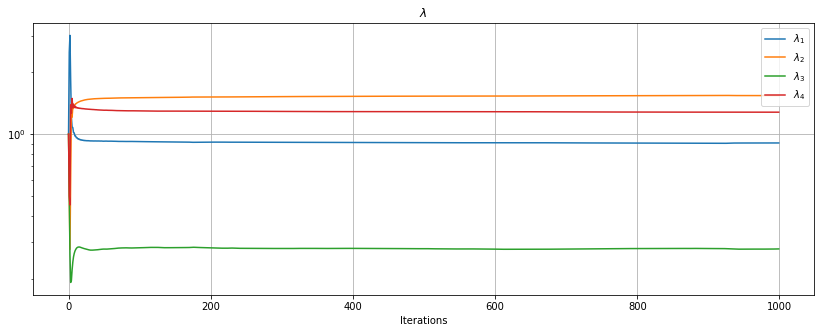

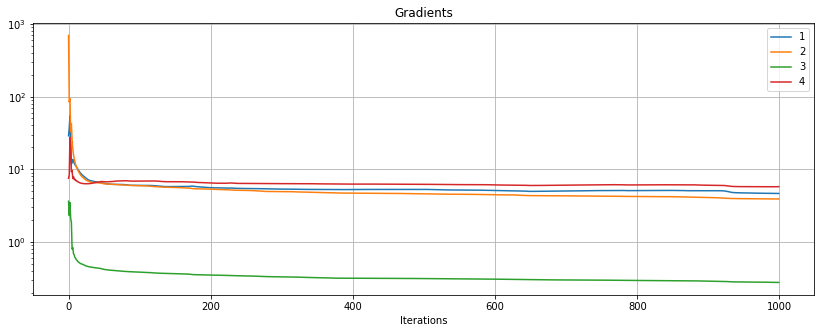

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


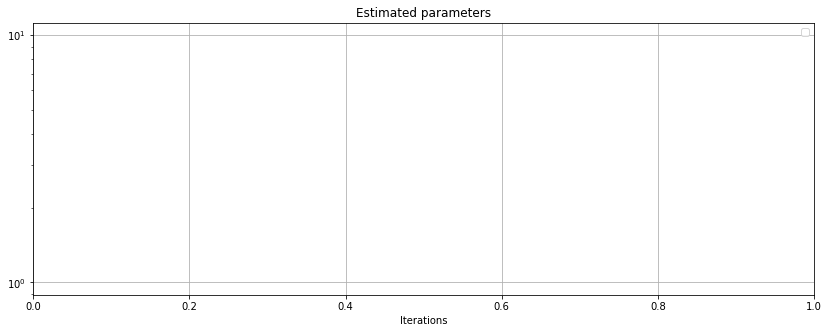

In [37]:
plot_result(merge_dict(results_KM), modelKM,start =0,
            param_names=pde_resKM.parameter_names(), yscale="log")#, y_lims=[0.01, 2])

In [38]:
modelKM.optimizer.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [39]:
results_KM2 = modelKM.train(epochs = 20+1,
                          batch_size = 525,
                          dataset = ds,
                          print_interval=1,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 5.15187134, total regularise loss: 6.14734459

Observation_Loss ->  (1): 0.00042119  (2): 0.00053605 
Loss_Koch_Meinhard ->  (1): 0.00011897  (2): 0.00053375 


lambdas (1): 0.90656602 lambdas (2): 1.53763676 lambdas (3): 0.27832705 lambdas (4): 1.27747011 

Time taken: 224.67s

Start of epoch 1
Training observations acc over epoch: 0.00000000
total loss: 5.15330620, total regularise loss: 6.14896011

Observation_Loss ->  (1): 0.00042149  (2): 0.00053621 
Loss_Koch_Meinhard ->  (1): 0.00011897  (2): 0.00053373 


lambdas (1): 0.86980784 lambdas (2): 1.63907719 lambdas (3): 0.26849121 lambdas (4): 1.22262394 

Time taken: 88.38s

Start of epoch 2
Training observations acc over epoch: 0.00000000
total loss: 5.20550887, total regularise loss: 6.16535711

Observation_Loss ->  (1): 0.00044468  (2): 0.00049840 
Loss_Koch_Meinhard ->  (1): 0.00011829  (2): 0.00056536 


lambdas (1): 0.88302356 lambdas (2): 1.606488

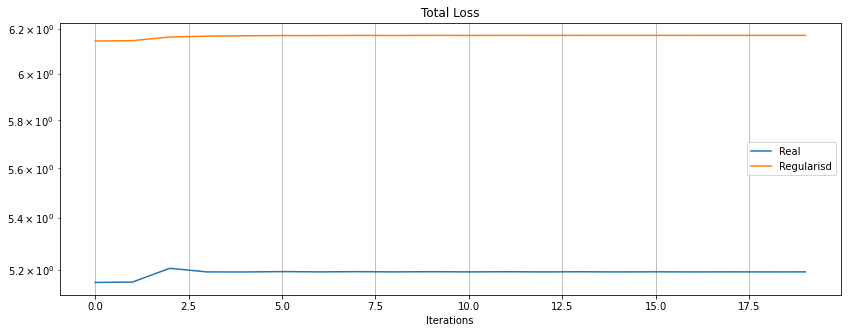

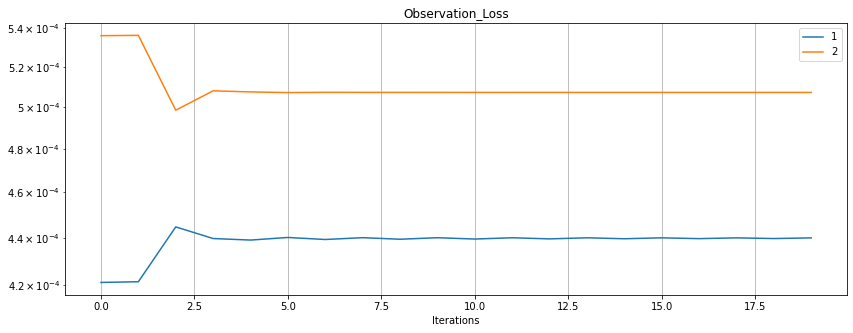

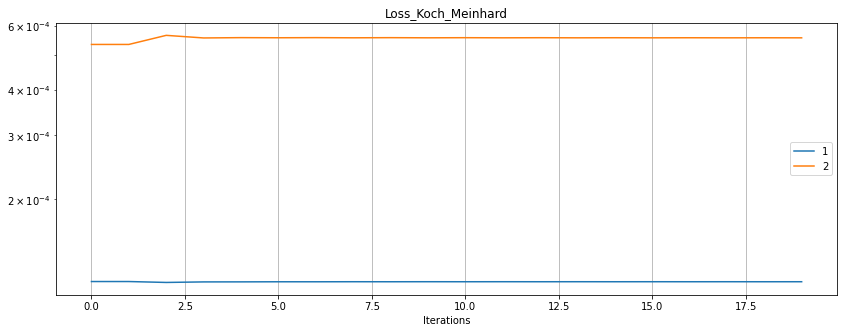

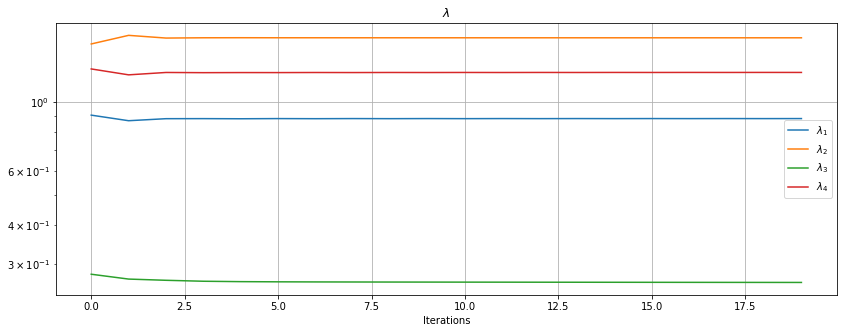

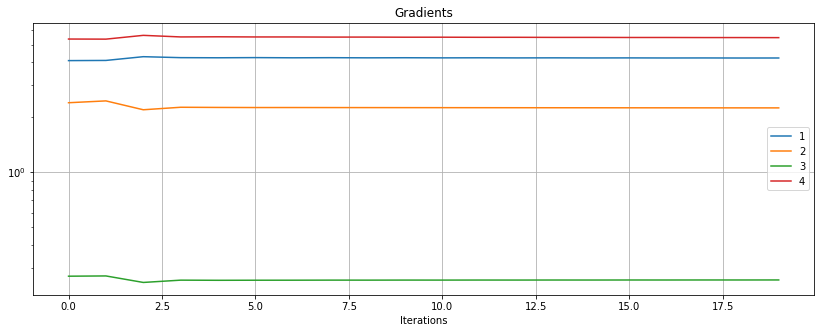

In [41]:
plot_result(merge_dict(results_KM2), modelKM,start =0, yscale="log")

In [42]:
modelKM.optimizer.lr.assign(1e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-05>

In [51]:
results_KM3 = modelKM.train(epochs = 40+1,
                          batch_size = 525,
                          dataset = ds,
                          print_interval=1,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 5.16468305, total regularise loss: 6.14159107

Observation_Loss ->  (1): 0.00043631  (2): 0.00050554 
Loss_Koch_Meinhard ->  (1): 0.00011876  (2): 0.00055335 


lambdas (1): 0.88358295 lambdas (2): 1.60968184 lambdas (3): 0.26180479 lambdas (4): 1.24493027 

Time taken: 198.69s

Start of epoch 1
Training observations acc over epoch: 0.00000000
total loss: 5.16433261, total regularise loss: 6.14043522

Observation_Loss ->  (1): 0.00043672  (2): 0.00050509 
Loss_Koch_Meinhard ->  (1): 0.00011867  (2): 0.00055337 


lambdas (1): 0.86690998 lambdas (2): 1.65170288 lambdas (3): 0.25774878 lambdas (4): 1.22363830 

Time taken: 92.31s

Start of epoch 2
Training observations acc over epoch: 0.00000000
total loss: 5.18437339, total regularise loss: 6.14421129

Observation_Loss ->  (1): 0.00044579  (2): 0.00049321 
Loss_Koch_Meinhard ->  (1): 0.00011851  (2): 0.00056260 


lambdas (1): 0.86957717 lambdas (2): 1.649166

KeyboardInterrupt: 

# Second test: No fixed parameter but more data for training

In [19]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size


#T_test_index = -1#119
#T =224
index =0
#T = 384.
T = t_star[index]
#T = 3000
#print(t_star[T_test_index])
print(T)
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(T, N2)  # 1 x N2
test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)

100.0


In [20]:
output_test = pinnKM(test_d)
output_test = np.array([output_test[:, i].numpy().reshape((x_size, y_size)) 
                        for i in range(output_test.shape[1])]) 

In [21]:
#test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)
test_outputs = np.zeros((test_d.shape[0], 2))
#test_pde_u = np.zeros(test_d.shape[0])
#test_pde_v = np.zeros(test_d.shape[0])
pde_u, pde_v = pde_resKM.residual(pinnKM, test_d)
test_outputs = np.array([test_outputs[..., i].reshape(x_size, y_size) for i in range(2)])
#test_outputs[i] = outs.numpy()
test_pde_u = pde_u.numpy().reshape(x_size, y_size)
test_pde_v = pde_v.numpy().reshape(x_size, y_size)

In [22]:
print(np.mean((output_test[0, ...]-data[0,:,:, index])**2))
print(np.mean((output_test[1, ...]-data[1,:,:, index])**2))
print(np.sqrt(np.mean((output_test[0, ...]-data[0,:,:, index])**2)))
print(np.sqrt(np.mean((output_test[1, ...]-data[1,:,:, index])**2)))
print(np.max(test_pde_u))
print(np.max(test_pde_v))
print(np.sqrt(np.mean(test_pde_u**2)))
print(np.sqrt(np.mean(test_pde_v**2)))

0.000765909601233515
0.0009513907077705609
0.027675071837910646
0.03084462202346725
0.068697415
0.094090156
0.009672468
0.025488261


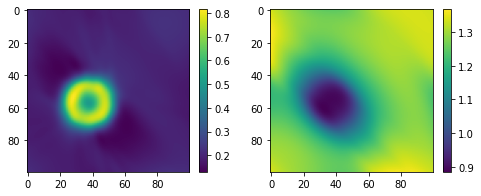

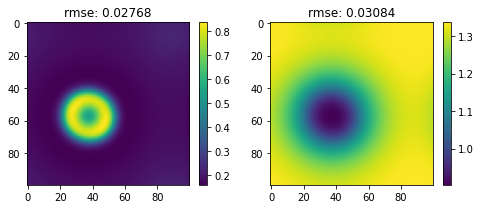

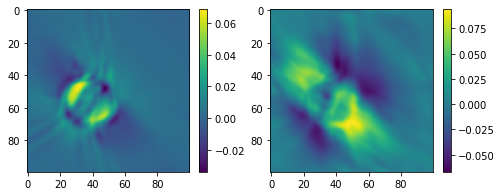

In [23]:

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(output_test[0, ...])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(output_test[1, ...])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
rmse = np.sqrt(np.mean( (output_test[0, ...]-data[0,:,:, index])**2 ))#/np.max(data[0,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
rmse = np.sqrt(np.mean( (output_test[1, ...]-data[1,:,:, index])**2 ))#/np.max(data[1,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

#index = 0
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)
plt.show()

In [24]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [25]:
y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy = derivatives(pinnKM, test_d)
D_u = pde_resKM.D_u.get_value(test_d)
D_v = pde_resKM.D_v.get_value(test_d)
sigma_u = pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u
sigma_v = pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v
mu_u = pde_resKM.mu_u.get_value(test_d)
rho_u = pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v
rho_v = pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u
kappa_u = pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u
#A = kappa_u = pde_resKM.A.get_value(test_d) 
#B = kappa_u = pde_resKM.B.get_value(test_d) 

In [26]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = x_size * y_size/ L**2
diffusion_u_space = D_u * dxdy * diffusion([x_size, y_size], u.numpy().reshape(x_size, y_size))
diffusion_v_space = D_v * dxdy * diffusion([x_size, y_size], v.numpy().reshape(x_size, y_size))


f = u * u * v / (1.0 + kappa_u * u * u)
non_lin_u = -rho_u * f
non_lin_v = rho_v * f
f_u = - rho_u * f + mu_u * u - sigma_u
f_v = rho_v * f - sigma_v
d_t_u = - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
d_t_v = -D_v * (v_xx + v_yy) + rho_v * f - sigma_v


diff_Y = np.array([[dxdy * [0.005, 0.2][c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)
#u2v = u * u * v

#non_lin_u = -u2v
#non_lin_v = u2v
#f_u = - A + (B + 1) * u - u2v
#f_v = - B * u + u2v
#d_t_u = - D_u * (u_xx + u_yy) + f_u
#d_t_v = - D_v * (v_xx + v_yy) + f_v

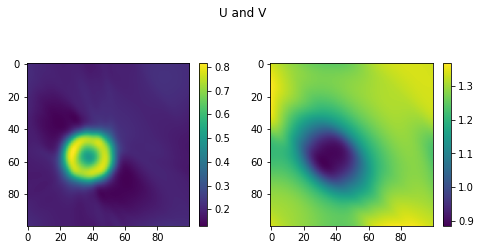

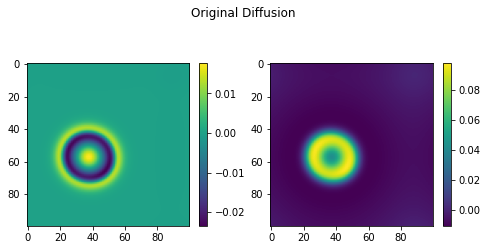

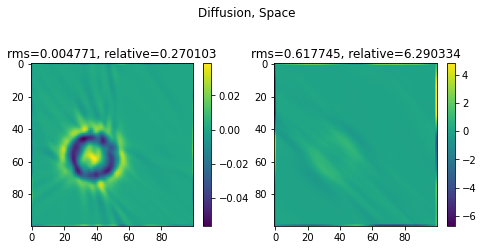

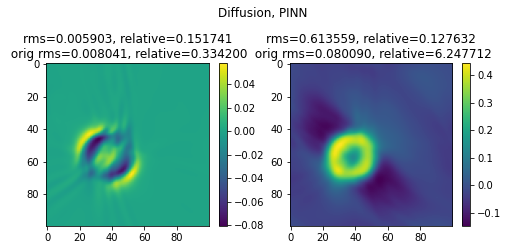

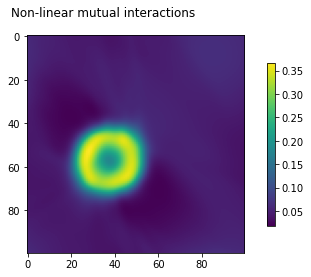

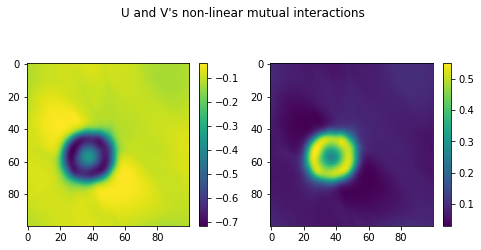

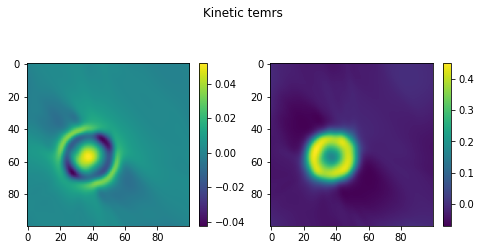

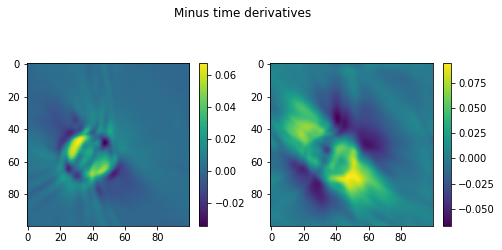

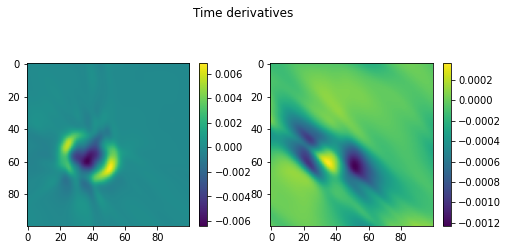

In [27]:
#index = 0
_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V")
plt.subplot(121)
plt.imshow(u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Original Diffusion")
plt.subplot(121)
plt.imshow(diff_Y[0, :, :, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(diff_Y[1, :, :, index])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, Space")
plt.subplot(121)
rms = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u_space)**2))
relative_rms = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_u_space)
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v_space)**2))
relative_rms = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_v_space)
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, PINN")
plt.subplot(121)
rms = np.sqrt(np.mean((diffusion_u.numpy().reshape(x_size, y_size)-diffusion_u_space)**2))
relative_rms = rms/np.max(diffusion_u_space)
rms2 = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diffusion_v.numpy().reshape(x_size, y_size)-diffusion_v_space)**2))
relative_rms = rms/np.max(diffusion_v_space)
rms2 = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()



_ = plt.figure(figsize=(8,4))
plt.suptitle("Non-linear mutual interactions")
plt.imshow(f.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V's non-linear mutual interactions")
plt.subplot(121)
plt.imshow(non_lin_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(non_lin_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Kinetic temrs")
plt.subplot(121)
plt.imshow(f_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(f_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Minus time derivatives")
plt.subplot(121)
plt.imshow(d_t_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(d_t_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Time derivatives")
plt.subplot(121)
plt.imshow(u_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()